https://www1.nyc.gov/site/doh/business/food-operators/the-inspection-process.page

See https://www1.nyc.gov/assets/doh/downloads/pdf/rii/blue-book.pdf 

In [2]:
!sudo pip install pandas-profiling[notebook]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Download Latest Dataset

In [3]:
# !curl 'https://data.cityofnewyork.us/api/views/43nn-pn8j/rows.csv?accessType=DOWNLOAD' -o restaurants.csv

In [4]:
import pandas as pd
import numpy as np
df = pd.read_csv("restaurants.csv", dtype = 'object')

In [5]:
initial_size = len(df)
initial_size

288505

In [6]:
# Render our plots inline
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [7]:
df.dtypes

CAMIS                    object
DBA                      object
BORO                     object
BUILDING                 object
STREET                   object
ZIPCODE                  object
PHONE                    object
CUISINE DESCRIPTION      object
INSPECTION DATE          object
ACTION                   object
VIOLATION CODE           object
VIOLATION DESCRIPTION    object
CRITICAL FLAG            object
SCORE                    object
GRADE                    object
GRADE DATE               object
RECORD DATE              object
INSPECTION TYPE          object
Latitude                 object
Longitude                object
Community Board          object
Council District         object
Census Tract             object
BIN                      object
BBL                      object
NTA                      object
dtype: object

In [8]:
# Adding underscores in all column names
cols = df.columns
cols = cols.map(lambda x: x.replace(' ', '_').upper())
df.columns = cols

In [9]:
df.dtypes

CAMIS                    object
DBA                      object
BORO                     object
BUILDING                 object
STREET                   object
ZIPCODE                  object
PHONE                    object
CUISINE_DESCRIPTION      object
INSPECTION_DATE          object
ACTION                   object
VIOLATION_CODE           object
VIOLATION_DESCRIPTION    object
CRITICAL_FLAG            object
SCORE                    object
GRADE                    object
GRADE_DATE               object
RECORD_DATE              object
INSPECTION_TYPE          object
LATITUDE                 object
LONGITUDE                object
COMMUNITY_BOARD          object
COUNCIL_DISTRICT         object
CENSUS_TRACT             object
BIN                      object
BBL                      object
NTA                      object
dtype: object

## Cleaning Individual Columns

In [10]:
df.CAMIS.isnull().sum()

0

In [11]:
df.DBA.isnull().sum()

1431

In [12]:
# Checks that all CAMIS values correpond to a unique DBA value
# ie the same CAMIS always has the same DBA
max_cardinality = df[['DBA','CAMIS']].pivot_table(
    index='CAMIS',
    values='DBA',
    aggfunc=pd.Series.nunique
).DBA.max()

assert(max_cardinality==1)

### INSPECTION_TYPE

In [13]:
df.INSPECTION_TYPE.value_counts()

Cycle Inspection / Initial Inspection                          166340
Cycle Inspection / Re-inspection                                58731
Pre-permit (Operational) / Initial Inspection                   29650
Pre-permit (Operational) / Re-inspection                        11226
Administrative Miscellaneous / Initial Inspection                5255
Pre-permit (Non-operational) / Initial Inspection                2734
Cycle Inspection / Reopening Inspection                          2623
Smoke-Free Air Act / Initial Inspection                          1201
Pre-permit (Operational) / Compliance Inspection                 1129
Administrative Miscellaneous / Re-inspection                     1115
Pre-permit (Operational) / Reopening Inspection                  1002
Inter-Agency Task Force / Initial Inspection                      862
Trans Fat / Initial Inspection                                    844
Calorie Posting / Initial Inspection                              413
Cycle Inspection / C

In [14]:
sum(df.INSPECTION_TYPE.isnull())

4017

In [15]:
# We create a column "TO_DELETE" to mark the entries that we are not interested in.
# We will perform first the inspection/analysis on all the attributes, and then delete the rows

# Drop all cases where inspection is NULL
df['TO_DELETE'] = df.INSPECTION_TYPE.isnull()

In [16]:
sum(df['TO_DELETE'])

4017

In [17]:
# Break INSPECTION_TYPE into two columns, and also delete some inspection types

# Create a new column that contains the results of the split on the '/'' character
lst = df.INSPECTION_TYPE.str.split(' / ').values.tolist()
lst = [ l if type(l)==type(list()) else ['',''] for l in lst ]
t = pd.DataFrame(lst)


In [18]:
t[0].value_counts()

Cycle Inspection                228089
Pre-permit (Operational)         43076
Administrative Miscellaneous      6488
                                  4017
Pre-permit (Non-operational)      2989
Smoke-Free Air Act                1486
Trans Fat                         1015
Inter-Agency Task Force            862
Calorie Posting                    483
Name: 0, dtype: int64

In [19]:
t[1].value_counts()

Initial Inspection              207299
Re-inspection                    71783
                                  4017
Reopening Inspection              3673
Compliance Inspection             1623
Second Compliance Inspection        81
Limited Inspection                  29
Name: 1, dtype: int64

In [20]:
# Keep only cycle inspections. Ignore admin, pre-permit, transfat, and calorie posting inspections
# We will only keep the initial inspections and the re-inspections. The other types are border cases

keep = df.INSPECTION_TYPE.isin( ['Cycle Inspection / Initial Inspection', 'Cycle Inspection / Re-inspection'])


In [21]:
# Check how many we will drop: ~keep means negation on the keep and summing up adds up the 'True'
sum(~keep)

63434

In [22]:
# Adding the "not keep" entries into the TO_DELETE

# The |= operator is a shortcut for df['TO_DELETE'] = df['TO_DELETE'] | ~keep
# We use the bit-OR operator (|), as we want to keep the existing deletions, and add the ones from the 
# additional condition
df['TO_DELETE'] |= ~keep

In [23]:
# Rename the two entries that we will keep into simpler values

df["INSPECTION_TYPE"].replace(
    to_replace='Cycle Inspection / Initial Inspection',
    value = 'Initial Inspection',
    inplace=True
)
df["INSPECTION_TYPE"].replace(
    to_replace='Cycle Inspection / Re-inspection',
    value = 'Re-inspection',
    inplace=True
)

In [24]:
sum(df['TO_DELETE'])

63434

### BORO

In [25]:
df.BORO.value_counts()

Manhattan        111188
Brooklyn          71059
Queens            68536
Bronx             28394
Staten Island      9236
0                    92
Name: BORO, dtype: int64

In [26]:
sum(df.BORO.isnull())

0

In [27]:
# Replace the "Missing" in BORO with null
# df.BORO = df.BORO.replace('Missing', np.NaN)

In [28]:
missing = set(df[df.BORO.isnull()].CAMIS)
# missing

In [29]:
sum(df.BORO == '0')

92

In [30]:
# Remove the entries with null/missing BORO value
# Not worth trying to fix.
df['TO_DELETE'] |= (df.BORO == '0')

In [31]:
sum(df['TO_DELETE'])

63497

### BUILDING

In [32]:
sum(df.BUILDING.isnull())

405

In [33]:
# Inspect the entries with missing street number
# df[df.BUILDING.isnull()]

In [34]:
# Dropping the violations listed without street number
# Most are in train stations and in airports, but there
# are a few others in 'regular' locations

df['TO_DELETE'] |= df.BUILDING.isnull()

In [35]:
sum(df['TO_DELETE'])

63818

### STREET

In [36]:
# Check that no street values are empty
sum(df.STREET.isnull())

21

In [37]:
df['TO_DELETE'] |= df.STREET.isnull()

In [38]:
sum(df['TO_DELETE'])

63818

### ZIPCODE

In [39]:
sum(df.ZIPCODE.isnull())

4137

In [40]:
len(set(df[df.ZIPCODE.isnull()].CAMIS))

469

In [41]:
df['TO_DELETE'] |= df.ZIPCODE.isnull()

In [42]:
# TODO: Fill in the missing zip codes, perhaps with geocoding of the addresses
# For now, we just drop the cases without ZIPCODE

### CUISINE DESCRIPTION

In [43]:
df.CUISINE_DESCRIPTION.value_counts()

American          53500
Chinese           29459
Pizza             17418
Coffee/Tea        13943
Latin American    12269
                  ...  
Czech                18
Basque               10
Lebanese             10
New French            6
Armenian              3
Name: CUISINE_DESCRIPTION, Length: 87, dtype: int64

In [44]:
len(df.CUISINE_DESCRIPTION.value_counts())

87

In [45]:
sum(df.CUISINE_DESCRIPTION.isnull())

4017

In [46]:
'''
df.CUISINE_DESCRIPTION.replace(
    to_replace='Café/Coffee/Tea',
    value = 'Cafe',
    inplace=True
)

df.CUISINE_DESCRIPTION.replace(
    to_replace='Latin (Cuban, Dominican, Puerto Rican, South & Central American)',
    value = 'Latin',
    inplace=True
)
'''

"\ndf.CUISINE_DESCRIPTION.replace(\n    to_replace='Café/Coffee/Tea',\n    value = 'Cafe',\n    inplace=True\n)\n\ndf.CUISINE_DESCRIPTION.replace(\n    to_replace='Latin (Cuban, Dominican, Puerto Rican, South & Central American)',\n    value = 'Latin',\n    inplace=True\n)\n"

### INSPECTION_DATE

In [47]:
df["INSPECTION_DATE"] = pd.to_datetime(df["INSPECTION_DATE"], format="%m/%d/%Y")

In [48]:
df.INSPECTION_DATE.describe(datetime_is_numeric=True)

count                           288505
mean     2018-02-28 01:25:32.101003520
min                1900-01-01 00:00:00
25%                2018-11-27 00:00:00
50%                2019-08-12 00:00:00
75%                2020-03-07 00:00:00
max                2022-05-20 00:00:00
Name: INSPECTION_DATE, dtype: object

In [49]:
sum(df.INSPECTION_DATE.isnull())

0

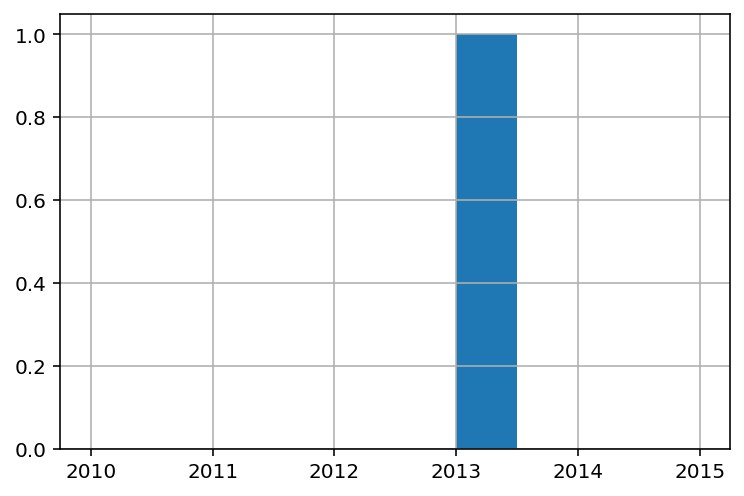

In [50]:
df.INSPECTION_DATE.hist(range=(pd.to_datetime('2010-01-01'),pd.to_datetime('2014-12-31')))

In [51]:
# Drop the 1900-01-01 inspections. These are all incorrect and we cannot fix them
df['TO_DELETE'] |= (df['INSPECTION_DATE'] == '1900-01-01')

In [52]:
# After analysis, it seems that we have minimal number of inspections before 2015
df['TO_DELETE'] |=  (df['INSPECTION_DATE'] < '2015-01-01')

In [53]:
sum(df['TO_DELETE'])

67283

### ACTION

In [54]:
sum(df.ACTION.isnull())

4017

In [55]:
df["ACTION"].value_counts()

Violations were cited in the following area(s).                                                                                       267619
Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.     10860
Establishment re-opened by DOHMH.                                                                                                       3019
No violations were recorded at the time of this inspection.                                                                             2934
Establishment re-closed by DOHMH.                                                                                                         56
Name: ACTION, dtype: int64

In [56]:
df["ACTION"].replace(
    to_replace='Violations were cited in the following area(s).',
    value = 'Violations found',
    inplace=True
)

In [57]:
df["ACTION"].replace(
    to_replace='No violations were recorded at the time of this inspection.',
    value = 'No violations',
    inplace=True
)

In [58]:
df["ACTION"].replace(
    to_replace='Establishment Closed by DOHMH. Violations were cited in the following area(s) and those requiring immediate action were addressed.',
    value = 'Establishment closed',
    inplace=True
)

In [59]:
df["ACTION"].replace(
    to_replace='Establishment re-opened by DOHMH.',
    value = 'Establishment re-opened',
    inplace=True
)

In [60]:
df["ACTION"].replace(
    to_replace='Establishment re-closed by DOHMH.',
    value = 'Establishment re-closed',
    inplace=True
)

In [61]:
df["ACTION"].value_counts()

Violations found           267619
Establishment closed        10860
Establishment re-opened      3019
No violations                2934
Establishment re-closed        56
Name: ACTION, dtype: int64

In [62]:
# Drop the Establishment re-opened and re-closed cases
# as the inspection scores for these can be misleading
df['TO_DELETE'] |=  (df.ACTION == 'Establishment re-closed')
df['TO_DELETE'] |=  (df.ACTION == 'Establishment re-opened')
df['TO_DELETE'] |=  df.ACTION.isnull()

In [63]:
sum(df['TO_DELETE'])

67283

### SCORE

In [64]:
df["SCORE"] = pd.to_numeric(df["SCORE"])

In [65]:
df.SCORE.describe()

count    275016.000000
mean         21.081493
std          15.312783
min           0.000000
25%          11.000000
50%          16.000000
75%          27.000000
max         157.000000
Name: SCORE, dtype: float64

In [66]:
len(df)

288505

In [67]:
len( df[ df.SCORE < 0 ] )

0

In [68]:
df['TO_DELETE'] |= (df.SCORE < 0)

In [69]:
sum(df['TO_DELETE'])

67283

In [70]:
# Drop cases reported as "no violations but with positive score"
df['TO_DELETE'] |= ((df.SCORE > 0)  & (df.ACTION == 'No violations'))

# Drop cases with zero score but with violations found
df['TO_DELETE'] |= ((df.SCORE == 0)  & (df.ACTION == 'Violations found'))

In [71]:
# Drop incorrectly scored inspections
df['TO_DELETE'] |=  (df.GRADE=='A') & (df.SCORE>13)

df['TO_DELETE'] |=  (df.GRADE=='B') & ( (df.SCORE<14) | (df.SCORE>27) )

# Drop incorrectly scored inspections
df['TO_DELETE'] |=  (df.GRADE=='C') & (df.SCORE<28)


In [72]:
sum(df['TO_DELETE'])

67375

### RECORD_DATE

In [73]:
df["RECORD_DATE"] = pd.to_datetime(df["RECORD_DATE"], format="%m/%d/%Y")

In [74]:
# Drop record date field, as it only contains a single value
df = df.drop( 'RECORD_DATE', axis = 'columns')

### GRADE

In [75]:
df.GRADE.value_counts()

A    110443
B     16388
C      6904
N      5938
Z      2660
P      1541
G         1
Name: GRADE, dtype: int64

In [76]:
sum(df.GRADE.isnull())

144630

In [77]:
df.query(" GRADE == 'G' ")

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE_DESCRIPTION,INSPECTION_DATE,ACTION,...,INSPECTION_TYPE,LATITUDE,LONGITUDE,COMMUNITY_BOARD,COUNCIL_DISTRICT,CENSUS_TRACT,BIN,BBL,NTA,TO_DELETE
222070,50043665,MEXICO EN LA PIEL,Brooklyn,5904,5 AVENUE,11220,7187650001,Mexican,2019-11-08,Establishment re-opened,...,Cycle Inspection / Reopening Inspection,40.639960133856,-74.015677529764,307,38,007400,3324492,3008630040,BK32,True


In [78]:
# Seems that all the "G" correspond to "A"
df.GRADE.replace('G', 'A', inplace=True)

In [79]:
# P assigned to 'Establishment re-opened' actions
df.query(" GRADE == 'P' ")

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE_DESCRIPTION,INSPECTION_DATE,ACTION,...,INSPECTION_TYPE,LATITUDE,LONGITUDE,COMMUNITY_BOARD,COUNCIL_DISTRICT,CENSUS_TRACT,BIN,BBL,NTA,TO_DELETE
33,50082407,GRANDMA'S ORIGINAL PIZZERIA,Brooklyn,6918,3 AVENUE,11209,7188334646,Pizza,2018-11-19,Establishment re-opened,...,Pre-permit (Operational) / Reopening Inspection,40.63549246291,-74.026143073284,310,43,006800,3145626,3058710052,BK31,True
209,50067646,BREAD & BUTTER,Manhattan,25,WEST 56 STREET,10019,2127670444,Sandwiches,2019-10-15,Establishment re-opened,...,Cycle Inspection / Reopening Inspection,40.762729442799,-73.975488991143,105,04,011201,1081136,1012720020,MN17,True
320,50018603,SPICY PIZZA,Queens,4322,43RD AVE,11104,7187066655,Pizza,2018-11-07,Establishment re-opened,...,Cycle Inspection / Reopening Inspection,40.745176721685,-73.920849288169,402,26,018300,4001931,4001620023,QN31,True
1524,41703394,PIONEERS BAR & LOUNGE,Manhattan,134,WEST 29 STREET,10001,2127142222,American,2019-07-22,Establishment re-opened,...,Cycle Inspection / Reopening Inspection,40.747114039331,-73.991190383844,105,03,009500,1015129,1008040059,MN17,True
1683,41443460,CASA NOVA,Staten Island,3555,VICTORY BOULEVARD,10314,7186821331,Italian,2018-08-03,Establishment re-opened,...,Cycle Inspection / Reopening Inspection,40.601115596831,-74.176410664865,502,50,029103,5036682,5021620192,SI05,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287180,50118279,IPIZZA,Manhattan,707,9 AVENUE,10019,2122456260,Pizza,2022-02-24,Establishment re-opened,...,Pre-permit (Operational) / Reopening Inspection,40.762470846186,-73.98970108469,104,03,012700,1026604,1010580032,MN15,True
287393,50071617,BELLA PIZZA & GRILL,Queens,8917,165TH ST,11432,7188802740,Pizza,2018-06-13,Establishment re-opened,...,Cycle Inspection / Reopening Inspection,40.707367266488,-73.796086035078,412,27,046000,4209605,4097950065,QN61,True
287499,41352974,SAKURA 6 JAPANESE CUISINE,Brooklyn,837,MANHATTAN AVENUE,11222,7183497888,Japanese,2019-01-04,Establishment re-opened,...,Cycle Inspection / Reopening Inspection,40.728709591496,-73.953611701125,301,33,056100,3065102,3025730013,BK76,True
287508,50091489,AVOCADERIA,Brooklyn,55,WATER STREET,11201,9177437388,American,2019-07-20,Establishment re-opened,...,Pre-permit (Operational) / Reopening Inspection,40.703293906326,-73.992047363499,302,33,002100,3000019,3000260050,BK38,True


In [80]:
# P assigned to 'Establishment re-opened' actions
df.query(" GRADE == 'P' ").ACTION.value_counts()

Establishment re-opened    1541
Name: ACTION, dtype: int64

In [81]:
# P assigned to 'Reopening Inspection' inspection types
df.query(" GRADE == 'P' ").INSPECTION_TYPE.value_counts()

Cycle Inspection / Reopening Inspection            1249
Pre-permit (Operational) / Reopening Inspection     292
Name: INSPECTION_TYPE, dtype: int64

In [82]:
# df.query(" GRADE == 'Z' ").SCORE.hist(bins=100)

In [83]:
# TODO: Figure out what Z, and Not Yet Graded means in GRADE
# Until then, we just replace these values with NULL, keeping only the A, B, C grades

# 
df.GRADE.value_counts()

A    110444
B     16388
C      6904
N      5938
Z      2660
P      1541
Name: GRADE, dtype: int64

In [84]:
df['TO_DELETE'] |=  (df.GRADE=='Z')
df['TO_DELETE'] |=  (df.GRADE=='P')
df['TO_DELETE'] |=  (df.GRADE=='N') # Not Yet Graded
df['TO_DELETE'] |=  (df.GRADE=='Not Yet Graded')

### GRADE_DATE

In [85]:
df["GRADE_DATE"] = pd.to_datetime(df["GRADE_DATE"], format="%m/%d/%Y")


In [86]:
# Grade date and inspection date should be the same. 
assert np.abs((df.GRADE_DATE - df.INSPECTION_DATE).dropna()).sum().days == 0

In [87]:
# Check that is there is a grade date, a grade is also assigned
assert sum ( ~df.GRADE_DATE.isnull() & df.GRADE.isnull() )  == 0

In [88]:
# We do not need GRADE DATE if we have INSPECTION DATE
df = df.drop("GRADE_DATE", axis='columns')

### VIOLATION_CODE and VIOLATION_DESCRIPTION

In [89]:
df.VIOLATION_CODE.isnull().sum()

6974

In [90]:
# All the cases where violation code is NULL should be either cases that we delete
# or a "No violations" case
check = df[df.VIOLATION_CODE.isnull() & ~df.TO_DELETE & (df.ACTION!='No violations')]

assert( len(check) == 0 )


In [91]:
df.VIOLATION_DESCRIPTION.isnull().sum()

5378

In [92]:
# Checks that all VIOLATION_CODE has unique VIOLATION_DESCRIPTION
df[['VIOLATION_CODE','VIOLATION_DESCRIPTION']].drop_duplicates().pivot_table(
    index='VIOLATION_CODE',
    values='VIOLATION_DESCRIPTION',
    aggfunc=pd.Series.nunique
).sort_values('VIOLATION_DESCRIPTION', ascending=False)


,VIOLATION_DESCRIPTION
VIOLATION_CODE,
16C,2
02A,1
15L,1
15J,1
15I,1
...,...
04O,1
04N,1
04M,1


In [93]:
df['TO_DELETE'] |=  (df.VIOLATION_DESCRIPTION == 'Caloric content not posted on menus, menu boards or food tags, in a food service establishment that is 1 of 15 or more outlets operating the same type of business nationally under common ownership or control, or as a franchise or doing business under the same name, for each menu item that is served in portions, the size and content of which are standardized.')

In [265]:
# In the dataset we have a NULL violation, when there is no violation
# To make this more explicit, we replace NULL with 000
# df.VIOLATION_CODE.fillna('000', inplace=True)

In [490]:
df.VIOLATION_CODE.isnull().sum()

861

In [110]:
## LATITUDE and LONGITUDE

In [485]:
df['LONGITUDE'] = pd.to_numeric(df['LONGITUDE'])
df['LATITUDE'] = pd.to_numeric(df['LATITUDE'])

{'Establishment re-opened', 'No violations', 'Violations found', nan}

### MISC analysis

In [112]:
# Find the unique values in each column
# 
# df.describe(include = [np.object, 'category']).T['unique']
unique = df.describe(include = 'all').T['unique'].sort_values()

for column in unique.index:
    if unique[column] < 200:
        print(df[column].value_counts())
        print("=====")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  after removing the cwd from sys.path.


False    218118
True      70387
Name: TO_DELETE, dtype: int64
=====
Critical          151472
Not Critical      131655
Not Applicable      5378
Name: CRITICAL_FLAG, dtype: int64
=====
Violations found           267619
Establishment closed        10860
Establishment re-opened      3019
No violations                2934
Establishment re-closed        56
Name: ACTION, dtype: int64
=====
Manhattan        111188
Brooklyn          71059
Queens            68536
Bronx             28394
Staten Island      9236
0                    92
Name: BORO, dtype: int64
=====
A    110444
B     16388
C      6904
N      5938
Z      2660
P      1541
Name: GRADE, dtype: int64
=====
Initial Inspection                                             166340
Re-inspection                                                   58731
Pre-permit (Operational) / Initial Inspection                   29650
Pre-permit (Operational) / Re-inspection                        11226
Administrative Miscellaneous / Initial Inspection      

In [ ]:
df.dtypes

## Deleting Entries

In this section, we use the results of the analysis above, and delete (additional) entries that will not be useful in our analysis. (Note that it is important to document this, as others may want to go back to the original source, if the entries that we leave are not sufficient.)

In [96]:
len(df)

288505

In [97]:
assert len(df) == initial_size

In [98]:
df = df[ df.TO_DELETE == False].copy()

In [99]:
len(df)

218118

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [106]:
df[df.VIOLATION_CODE.isnull()].VIOLATION_DESCRIPTION

229       Facility not vermin proof. Harborage or condit...
415                                                     NaN
2222             Hot food item not held at or above 140º F.
2883      Cold food item held above 41º F (smoked fish a...
3041      Food not protected from potential source of co...
                                ...                        
286545    Evidence of mice or live mice present in facil...
286633                                                  NaN
286721    Facility not vermin proof. Harborage or condit...
288198                                                  NaN
288390    Food contact surface not properly washed, rins...
Name: VIOLATION_DESCRIPTION, Length: 861, dtype: object

In [ ]:
from pandas_profiling import ProfileReport
profile = ProfileReport(df, title="Pandas Profiling Report", explorative=True)

In [ ]:
profile

## Additional Data Quality Checks

In [496]:


assert sum(df.INSPECTION_TYPE.isnull()) == 0

assert len(set(df.INSPECTION_TYPE.values)) == 2

df["INSPECTION_TYPE"] =  pd.Categorical(df["INSPECTION_TYPE"], ordered=False)

In [497]:
# Check that no borough entries are empty
assert sum(df.BORO.isnull()) == 0

df["BORO"] =  pd.Categorical(df["BORO"], ordered=False)

In [498]:
# Check that no street numbers are empty
assert sum(df.BUILDING.isnull()) == 0

In [499]:
assert sum(df.STREET.isnull()) == 0

In [276]:

assert sum(df.CUISINE_DESCRIPTION.isnull()) == 0

df["CUISINE_DESCRIPTION"] =  pd.Categorical(df["CUISINE_DESCRIPTION"], ordered=False)

In [277]:
# We only keep three different actions
assert len(set(df.ACTION.values)) == 3

# No action is empty
assert sum(df.ACTION.isnull()) == 0

df["ACTION"] =  pd.Categorical(df["ACTION"], ordered=False)

In [500]:
# The below drops any grade values other than A, B, C, and converts the remaining entries to null
df["GRADE"] =  pd.Categorical(df["GRADE"], categories = ['A', 'B', 'C'], ordered=True)

# https://www1.nyc.gov/assets/doh/downloads/pdf/rii/how-we-score-grade.pdf
# 0-13 get an A
assert sum( (df.GRADE=='A') & (df.SCORE>13)) == 0

# 14-27 get a B
assert sum( (df.GRADE=='B') & ( (df.SCORE<14) | (df.SCORE>27) ) ) == 0

# 28- get a C
assert sum( (df.GRADE=='C') & (df.SCORE<28) ) == 0

# TODO: In principle, a NULL grade is only when the score is above 14, and it was an initial inspection

In [124]:
# Check that is there is a grade date, a grade is also assigned
# assert sum ( ~df.GRADE_DATE.isnull() & df.GRADE.isnull() ) == 0

In [502]:
df["VIOLATION_CODE"] =  pd.Categorical(df["VIOLATION_CODE"], ordered=False)
df["CRITICAL_FLAG"] =  pd.Categorical(df["CRITICAL_FLAG"], ordered=False)


In [507]:
df [ df.VIOLATION_CODE.isnull() ].VIOLATION_DESCRIPTION

229       Facility not vermin proof. Harborage or condit...
415                                                     NaN
2222             Hot food item not held at or above 140º F.
2883      Cold food item held above 41º F (smoked fish a...
3041      Food not protected from potential source of co...
                                ...                        
286545    Evidence of mice or live mice present in facil...
286633                                                  NaN
286721    Facility not vermin proof. Harborage or condit...
288198                                                  NaN
288390    Food contact surface not properly washed, rins...
Name: VIOLATION_DESCRIPTION, Length: 861, dtype: object

## Normalization

### Violation Codes

In [109]:
# Recreating the table at https://www1.nyc.gov/assets/doh/downloads/pdf/rii/ri-violation-penalty.pdf

violation_codes = df [ ['VIOLATION_CODE', 'VIOLATION_DESCRIPTION', 'CRITICAL_FLAG'] ].drop_duplicates()
violation_codes = violation_codes.rename( {
    'VIOLATION_DESCRIPTION' : 'DESCRIPTION',
    'CRITICAL_FLAG' : 'CRITICAL'
},  axis = 'columns').sort_values('VIOLATION_CODE').dropna().set_index('VIOLATION_CODE')
violation_codes

,DESCRIPTION,CRITICAL
VIOLATION_CODE,,
02A,Food not cooked to required minimum temperature.,Critical
02B,Hot food item not held at or above 140º F.,Critical
02C,Hot food item that has been cooked and refrige...,Critical
02D,Precooked potentially hazardous food from comm...,Critical
02E,"Whole frozen poultry or poultry breasts, other...",Critical
...,...,...
10J,Hand wash sign not posted,Not Critical
17A1,Dogs allowed sign not posted at or near the e...,Not Critical
19A1,Organics containers not provided,Not Critical


In [110]:
violation_codes

,DESCRIPTION,CRITICAL
VIOLATION_CODE,,
02A,Food not cooked to required minimum temperature.,Critical
02B,Hot food item not held at or above 140º F.,Critical
02C,Hot food item that has been cooked and refrige...,Critical
02D,Precooked potentially hazardous food from comm...,Critical
02E,"Whole frozen poultry or poultry breasts, other...",Critical
...,...,...
10J,Hand wash sign not posted,Not Critical
17A1,Dogs allowed sign not posted at or near the e...,Not Critical
19A1,Organics containers not provided,Not Critical


In [111]:
# Drop the description and critical part from the main dataframe
df = df.drop(['VIOLATION_DESCRIPTION' ,  'CRITICAL_FLAG'], axis='columns')

In [112]:
df

,CAMIS,DBA,BORO,BUILDING,STREET,ZIPCODE,PHONE,CUISINE_DESCRIPTION,INSPECTION_DATE,ACTION,...,INSPECTION_TYPE,LATITUDE,LONGITUDE,COMMUNITY_BOARD,COUNCIL_DISTRICT,CENSUS_TRACT,BIN,BBL,NTA,TO_DELETE
2,41090082,THE POUR HOUSE OF BAYRIDGE,Brooklyn,7901,3 AVENUE,11209,7184916658,American,2021-08-10,Violations found,...,Re-inspection,40.628445914396,-74.029011556766,310,43,006400,3150849,3059790011,BK31,False
3,41374597,DUNKIN,Queens,3015,STRATTON STREET,11354,7183210567,Donuts,2019-08-29,Violations found,...,Re-inspection,40.769752205055,-73.834744279195,407,20,086900,4100747,4043690001,QN22,False
4,50043786,CIENEGA LAS TLAYUDAS DE OAXACA,Queens,10432,CORONA AVE,11368,3473532366,Mexican,2019-09-06,Violations found,...,Re-inspection,40.743938291242,-73.857713941371,404,21,043900,4537585,4019357501,QN25,False
5,50063273,MAD DOG & BEANS MEXICAN CANTINA,Manhattan,5,EAST 38 STREET,10016,6469985722,Mexican,2018-12-03,Violations found,...,Initial Inspection,40.75073882625,-73.982199344364,105,04,008200,1017227,1008680008,MN20,False
6,41142196,UKUS,Queens,4208,30 AVENUE,11103,7182678587,Eastern European,2022-02-15,Violations found,...,Initial Inspection,40.763047847319,-73.913236374905,401,22,014900,4011927,4006960037,QN70,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288499,50007157,BAR PRIMI,Manhattan,325,BOWERY,10003,6464427860,Italian,2019-06-19,Violations found,...,Initial Inspection,40.72574885656,-73.992012202805,103,02,003602,1079109,1004580001,MN22,False
288500,50017748,HOME CHEF INTERNATIONAL FLAVORS,Queens,23114,MERRICK BLVD,11413,7187495745,Caribbean,2019-10-15,Violations found,...,Initial Inspection,40.675623464484,-73.739038257589,413,31,063200,4282638,4131580035,QN66,False
288501,50008239,NEW YORK YANKEES MVP CLUB,Bronx,1,EAST 161 STREET,10451,6469778510,American,2018-08-16,Violations found,...,Initial Inspection,40.829028434834,-73.928496459645,204,16,006300,2114490,2024930001,BX63,False
288502,50038787,TWO SAINTS,Brooklyn,753,NOSTRAND AVENUE,11216,3476278444,American,2022-05-06,Violations found,...,Initial Inspection,40.671496193998,-73.950335128033,308,35,031702,3032273,3012550004,BK61,False


### Restaurants

In [113]:
df.columns.values

array(['CAMIS', 'DBA', 'BORO', 'BUILDING', 'STREET', 'ZIPCODE', 'PHONE',
       'CUISINE_DESCRIPTION', 'INSPECTION_DATE', 'ACTION',
       'VIOLATION_CODE', 'SCORE', 'GRADE', 'INSPECTION_TYPE', 'LATITUDE',
       'LONGITUDE', 'COMMUNITY_BOARD', 'COUNCIL_DISTRICT', 'CENSUS_TRACT',
       'BIN', 'BBL', 'NTA', 'TO_DELETE'], dtype=object)

In [114]:
columns = ['CAMIS', 'DBA', 'BUILDING', 'STREET', 'ZIPCODE', 'BORO', 'PHONE', 
           'CUISINE_DESCRIPTION', 'LATITUDE', 'LONGITUDE',
       'COMMUNITY_BOARD', 'COUNCIL_DISTRICT', 'CENSUS_TRACT', 'BIN',
       'BBL', 'NTA']
restaurants =  df [ columns ].drop_duplicates()

In [115]:
# Check that we have the same attributes for a given CAMIS
# and the we do not have duplicate CAMIS values
assert len(restaurants) == len(set(restaurants.CAMIS.values))

In [288]:
restaurants.head(5)

,CAMIS,DBA,BUILDING,STREET,ZIPCODE,BORO,PHONE,CUISINE_DESCRIPTION,LATITUDE,LONGITUDE,COMMUNITY_BOARD,COUNCIL_DISTRICT,CENSUS_TRACT,BIN,BBL,NTA
2,41090082,THE POUR HOUSE OF BAYRIDGE,7901,3 AVENUE,11209,Brooklyn,7184916658,American,40.628446,-74.029012,310,43,006400,3150849,3059790011,BK31
3,41374597,DUNKIN,3015,STRATTON STREET,11354,Queens,7183210567,Donuts,40.769752,-73.834744,407,20,086900,4100747,4043690001,QN22
4,50043786,CIENEGA LAS TLAYUDAS DE OAXACA,10432,CORONA AVE,11368,Queens,3473532366,Mexican,40.743938,-73.857714,404,21,043900,4537585,4019357501,QN25
5,50063273,MAD DOG & BEANS MEXICAN CANTINA,5,EAST 38 STREET,10016,Manhattan,6469985722,Mexican,40.750739,-73.982199,105,04,008200,1017227,1008680008,MN20
6,41142196,UKUS,4208,30 AVENUE,11103,Queens,7182678587,Eastern European,40.763048,-73.913236,401,22,014900,4011927,4006960037,QN70


In [116]:
restaurants.PHONE.value_counts().head(20)

2124656273    43
9176186310    33
9172843260    29
2126159700    19
7182153308    15
2125867610    15
2125825472    14
__________    14
2124656302    14
7186566210    13
9178863304     8
7182246030     8
7187011630     8
2125325003     8
9175665727     7
5166038816     7
2129818588     7
6465881074     7
2123959280     7
2123544624     7
Name: PHONE, dtype: int64

In [ ]:
# __ = restaurants.PHONE.value_counts().head(10).index.values[7]

In [ ]:
# restaurants.PHONE.replace(to_replace=__, value=np.nan, inplace=True)

In [ ]:
# Citi Field concessions
# restaurants.query("PHONE == '7185958100'").head(5)

In [ ]:
# Madison Square Garden concession stands
# restaurants.query("PHONE == '2124656273'").head(5)

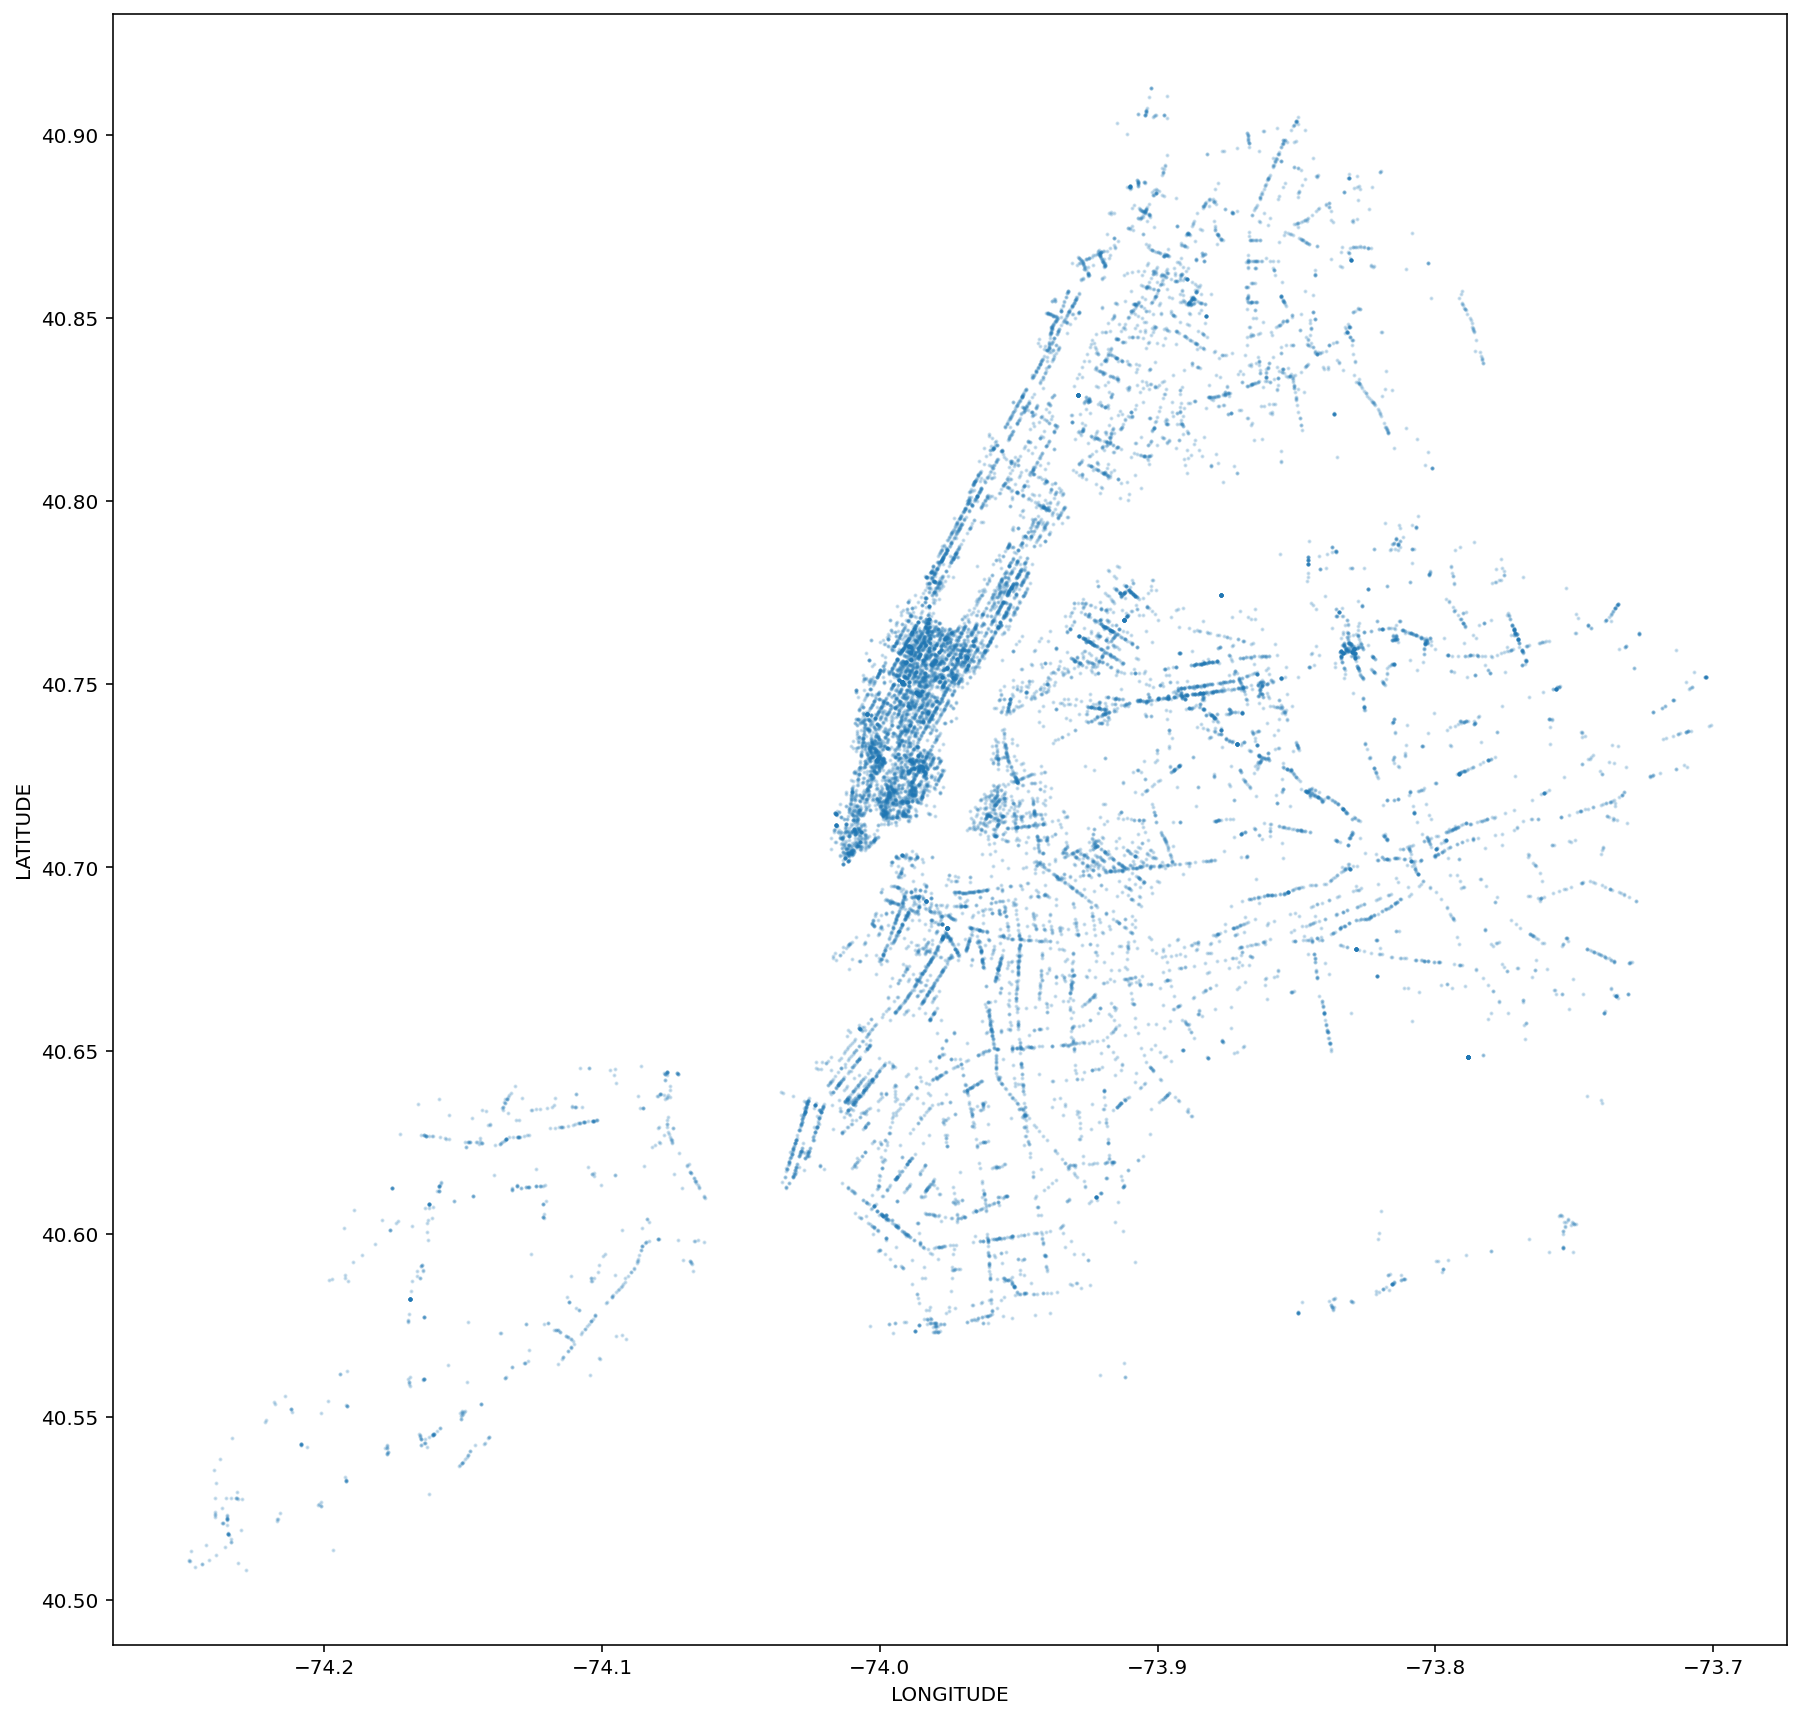

In [155]:
# restaurants.plot(kind='scatter', x='LONGITUDE', y='LATITUDE', alpha=0.2, s=1, figsize=(15,15))

In [117]:
df = df.drop (columns[1:], axis='columns')

In [118]:
df

,CAMIS,INSPECTION_DATE,ACTION,VIOLATION_CODE,SCORE,GRADE,INSPECTION_TYPE,TO_DELETE
2,41090082,2021-08-10,Violations found,04N,11.0,A,Re-inspection,False
3,41374597,2019-08-29,Violations found,02G,7.0,A,Re-inspection,False
4,50043786,2019-09-06,Violations found,02H,12.0,A,Re-inspection,False
5,50063273,2018-12-03,Violations found,08A,9.0,A,Initial Inspection,False
6,41142196,2022-02-15,Violations found,08A,21.0,NaN,Initial Inspection,False
...,...,...,...,...,...,...,...,...
288499,50007157,2019-06-19,Violations found,04H,25.0,NaN,Initial Inspection,False
288500,50017748,2019-10-15,Violations found,02G,27.0,NaN,Initial Inspection,False
288501,50008239,2018-08-16,Violations found,02B,13.0,A,Initial Inspection,False
288502,50038787,2022-05-06,Violations found,08A,18.0,NaN,Initial Inspection,False


### Inspections

In [119]:
# Each inspection has multiple violations. We want to keep just the inspections for now
inspection = df.drop('VIOLATION_CODE', axis='columns').drop_duplicates().sort_values(['INSPECTION_DATE', 'CAMIS'])

In [120]:
inspection

,CAMIS,INSPECTION_DATE,ACTION,SCORE,GRADE,INSPECTION_TYPE,TO_DELETE
50934,41030982,2015-04-03,Violations found,34.0,NaN,Initial Inspection,False
42729,41030982,2015-05-14,Violations found,9.0,A,Re-inspection,False
49699,50000233,2015-07-29,Violations found,11.0,A,Re-inspection,False
93480,41412172,2015-10-03,Violations found,10.0,A,Initial Inspection,False
11154,40944945,2015-10-14,Violations found,5.0,A,Re-inspection,False
...,...,...,...,...,...,...,...
13646,50096064,2022-05-20,Violations found,23.0,NaN,Initial Inspection,False
43241,50098171,2022-05-20,Violations found,10.0,A,Initial Inspection,False
67194,50100241,2022-05-20,Establishment closed,13.0,NaN,Initial Inspection,False
52323,50100302,2022-05-20,Violations found,54.0,NaN,Initial Inspection,False


In [121]:
# We create an ID for each inspection here
inspection = inspection.reset_index().drop('index', axis='columns').reset_index().rename({'index': 'INSPECTION_ID'}, axis='columns')

In [122]:
inspection.ACTION.value_counts()

Violations found        66372
Establishment closed     1261
No violations             446
Name: ACTION, dtype: int64

In [123]:
# Ensure that the inspection table contains 
# no duplicate pairs for 'INSPECTION_DATE', 'CAMIS'
pvt = inspection.pivot_table(
    index = ['INSPECTION_DATE', 'CAMIS'],
    values = 'INSPECTION_ID',
    aggfunc = 'count'
)
pvt [ pvt.INSPECTION_ID > 1 ]

# assert len(pvt [ pvt.INSPECTION_ID > 1 ]) == 0 

,,INSPECTION_ID
INSPECTION_DATE,CAMIS,
2017-11-04,40911114,2
2019-09-11,50051092,2


In [ ]:
# df[ (df.CAMIS =='41007054') & (df.INSPECTION_DATE == '2017-03-03')  ].sort_values('VIOLATION_CODE')

In [124]:
to_drop = inspection.query(" CAMIS =='50051092' and  INSPECTION_DATE == '2019-09-11' ").index.values[1]

inspection = inspection.drop(to_drop, axis='index')

In [125]:
to_drop = inspection.query(" CAMIS =='40911114' and  INSPECTION_DATE == '2017-11-04' ").index.values[1]

inspection = inspection.drop(to_drop, axis='index')

In [126]:
inspection.drop('TO_DELETE', axis='columns', inplace=True)

In [127]:
# Ensure that the inspection table contains 
# no duplicate pairs for 'INSPECTION_DATE', 'CAMIS'
pvt = inspection.pivot_table(
    index = ['INSPECTION_DATE', 'CAMIS'],
    values = 'INSPECTION_ID',
    aggfunc = 'count'
)
assert len(pvt [ pvt.INSPECTION_ID > 1 ]) == 0 

In [128]:
inspection.INSPECTION_TYPE.value_counts()

Initial Inspection    48356
Re-inspection         19721
Name: INSPECTION_TYPE, dtype: int64

In [129]:
inspection_stats = inspection.pivot_table(
    index = 'CAMIS',
    aggfunc = ['min', 'max', 'count'],
    values = 'INSPECTION_DATE'
)

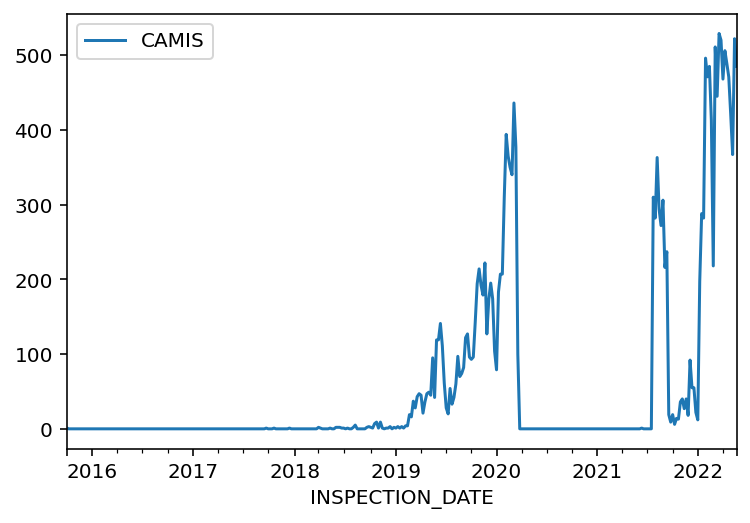

In [130]:
# Distribution of last inspection across all restaurants
inspection_stats['max'].sort_values('INSPECTION_DATE').reset_index().pivot_table(
    index='INSPECTION_DATE',
    aggfunc='count'
).resample('1W').sum().plot()

In [ ]:
# Longevity 
# (inspection_stats['max'] - inspection_stats['min'])['INSPECTION DATE'].sort_values()

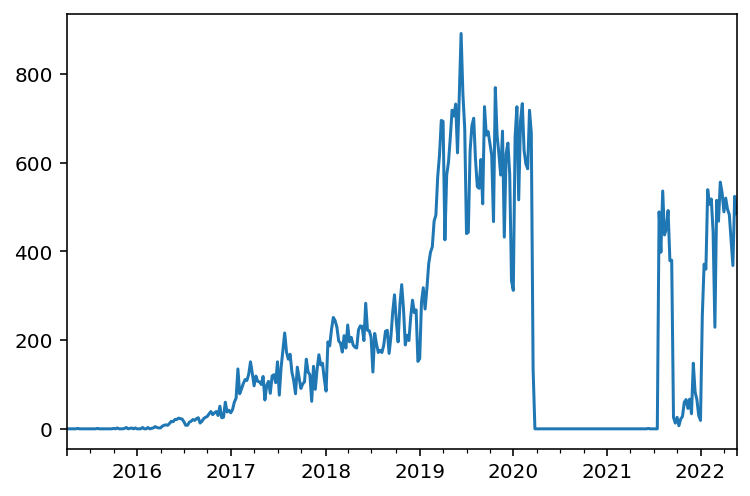

In [131]:
# Distribution of all inspections
inspection['INSPECTION_DATE'].value_counts().sort_index().resample('1W').sum().plot()

In [132]:
len(df)

218118

In [133]:
violations = pd.merge(
    inspection,
    df[ ['CAMIS', 'INSPECTION_DATE', 'VIOLATION_CODE' ] ],
    on= ['CAMIS', 'INSPECTION_DATE'],
    how = 'inner'
)
violations = violations[ ['INSPECTION_ID', 'VIOLATION_CODE'] ].drop_duplicates()
len(violations)

204358

In [134]:
print(f"Violations: {len(violations)}")
print(f"Inspections: {len(inspection)}")
print(f"Restaurants: {len(restaurants)}")
print(f"Violation Codes: {len(violation_codes)}")

Violations: 204358
Inspections: 68077
Restaurants: 18905
Violation Codes: 68


## Storing in MySQL


In [156]:
!sudo pip3 install -U -q PyMySQL sqlalchemy sql_magic

     |████████████████████████████████| 43 kB 1.1 MB/s 


In [135]:
import os
from sqlalchemy import create_engine

conn_string = 'mysql+pymysql://{user}:{password}@{host}/?charset=utf8mb4'.format(
    host = 'db.ipeirotis.org', 
    user = 'root',
    password = 'ae6jQniBS5muV27', #os.environ['MYSQL_PASSWORD'],
    encoding = 'utf8mb4')

engine = create_engine(conn_string)
con = engine.connect()

In [136]:
# Query to create a database
db_name = 'doh_restaurants'

sql = f"DROP DATABASE IF EXISTS {db_name}"
engine.execute(sql)

# Create a database
sql = f"CREATE DATABASE IF NOT EXISTS {db_name} DEFAULT CHARACTER SET 'utf8mb4'"
engine.execute(sql)

# And lets switch to the database
sql = f"USE {db_name}"
engine.execute(sql)

In [137]:
create_table_sql = '''
CREATE TABLE restaurants (
    CAMIS                      char(8),
    DBA varchar(80), 
    BUILDING varchar(10), 
    STREET varchar(40), 
    ZIPCODE char(5), 
    BORO ENUM('Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island')  ,
    PHONE char(10), 
    CUISINE_DESCRIPTION    varchar(30),
LATITUDE                float,
LONGITUDE               float,
COMMUNITY_BOARD          char(3),
COUNCIL_DISTRICT         char(2),
CENSUS_TRACT             char(6),
BIN                      char(7),
BBL                      char(10),
NTA                      char(4), 
PRIMARY KEY(CAMIS)   
) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4;
'''
engine.execute(create_table_sql)

create_table_sql = '''
CREATE TABLE inspections (
    INSPECTION_ID               int,
    CAMIS                      char(8),
    INSPECTION_DATE    date,
    ACTION                   ENUM('Violations found','Establishment closed','No violations'),
    SCORE                     smallint,
    GRADE                    char(1),
    INSPECTION_TYPE          ENUM('Initial Inspection','Re-inspection'),
    FOREIGN KEY(CAMIS) REFERENCES restaurants(CAMIS),
    PRIMARY KEY(INSPECTION_ID) 
) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4;
'''
engine.execute(create_table_sql)

create_table_sql = '''
CREATE TABLE violation_codes (
  VIOLATION_CODE     char(4),
  DESCRIPTION varchar(300),
  CRITICAL ENUM('Critical', 'Not Applicable', 'Not Critical'),
  PRIMARY KEY(VIOLATION_CODE) 

) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4;
'''
engine.execute(create_table_sql)


create_table_sql = '''
CREATE TABLE violations (
  INSPECTION_ID         int,
  VIOLATION_CODE     char(4),
  FOREIGN KEY(INSPECTION_ID) REFERENCES inspections(INSPECTION_ID),
FOREIGN KEY(VIOLATION_CODE) REFERENCES violation_codes(VIOLATION_CODE)
) ENGINE=InnoDB DEFAULT CHARSET=utf8mb4;
'''
engine.execute(create_table_sql)

In [138]:
violation_codes.reset_index().to_sql(
        name = 'violation_codes', 
        schema = db_name, 
        con = engine,
        if_exists = 'append',
        index = False, 
        chunksize = 1000)

In [139]:
restaurants.to_sql(
        name = 'restaurants', 
        schema = db_name, 
        con = engine,
        if_exists = 'append',
        index = False, 
        chunksize = 1000)

In [141]:
inspection.to_sql(
        name = 'inspections', 
        schema = db_name, 
        con = engine,
        if_exists = 'append',
        index = False, 
        chunksize = 1000)

In [142]:
violations.to_sql(
        name = 'violations', 
        schema = db_name, 
        con = engine,
        if_exists = 'append',
        index = False, 
        chunksize = 1000)